In [1]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import RandomizedSearchCV
from matplotlib import pyplot
import seaborn as sns
import matplotlib.pyplot as plt

/Users/zhaoyuxuan/anaconda3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/zhaoyuxuan/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
data = {}

data["CPU"] = pd.DataFrame()

source_dir = './CPU'
for f in os.listdir(source_dir):
    f_df = pd.read_csv("%s/%s" % (source_dir, f))
    hw_type, testname = f.split("-")
    f_df["hw_type"] = hw_type
    f_df["testname"] = testname
    data["CPU"] = pd.concat([data["CPU"], f_df])
print (data["CPU"].hw_type.value_counts())

d430      391104
c220g5    378288
m510      212908
c8220     180368
c6320     156456
xl170     151776
m400      150773
c220g1    119880
c6220      97928
r320       60622
c6420      58872
Name: hw_type, dtype: int64


In [3]:
data["Memory"] = pd.DataFrame()

source_dir = './Memory'
for f in os.listdir(source_dir):
    f_df = pd.read_csv("%s/%s" % (source_dir, f))
    hw_type, testname = f.split("-")
    f_df["hw_type"] = hw_type
    f_df["testname"] = testname
    data["Memory"] = pd.concat([data["Memory"], f_df])
print (data["Memory"].hw_type.value_counts())

d430      695296
c220g5    672512
c8220     649088
m510      573088
c6320     443648
c220g1    372416
xl170     269824
m400      200970
c6220     174208
r320      114112
c6420     104832
Name: hw_type, dtype: int64


In [4]:
data["Disk"] = pd.DataFrame()

source_dir = './Disk'
for f in os.listdir(source_dir):
    f_df = pd.read_csv("%s/%s" % (source_dir, f))
    hw_type, testname = f.split("-")
    f_df["hw_type"] = hw_type
    f_df["testname"] = testname
    data["Disk"] = pd.concat([data["Disk"], f_df])
print (data["Disk"].hw_type.value_counts())

m400      114768
d430       86896
c220g5     84048
c8220      82464
m510       72368
c220g1     71616
c6320      56384
xl170      33704
c6420      26208
c6220      21040
r320       14264
Name: hw_type, dtype: int64


In [5]:
cpu_raw = data["CPU"]
memory_raw = data["Memory"]
disk_raw = data["Disk"]

### Load data ###

In [6]:
cpd = {}

for dataset in ["CPU", "Memory", "Disk"]:

    results_dir = "./%s_results" % dataset
    if dataset not in cpd.keys():
        cpd[dataset] = {} 

    for f in os.listdir("%s" % results_dir):
        # Exclude hidden files (most likely thumbnails)
        if f[:2] != "._":
            print("Loading: %s/%s" % (results_dir, f))
            df = pd.read_csv("%s/%s" % (results_dir, f))
            print(len(df))

            if "aggr" in f:
                # Extract CPD threshold from the filename 
                lthreshold = float(f.split("-")[1])

                df["lthreshold"] = lthreshold
                if "aggr" not in cpd[dataset].keys():
                    cpd[dataset]["aggr"] = pd.DataFrame()
                cpd[dataset]["aggr"] = pd.concat([cpd[dataset]["aggr"], df], sort=False)

            if "indiv" in f:
                if "indiv" not in cpd[dataset].keys():
                    cpd[dataset]["indiv"] = pd.DataFrame()
                cpd[dataset]["indiv"] = pd.concat([cpd[dataset]["indiv"], df], sort=False)

            if "meta" in f:
                cpd[dataset]["meta"] = df

            if "segment-durations" in f:
                cpd[dataset]["segment-durations"] = df

Loading: ./CPU_results/indiv-0.70
283
Loading: ./CPU_results/aggr-1.00
4034
Loading: ./CPU_results/indiv-0.40
147
Loading: ./CPU_results/aggr-0.30
354
Loading: ./CPU_results/aggr-0.90
3951
Loading: ./CPU_results/aggr-0.70
3068
Loading: ./CPU_results/indiv-1.00
410
Loading: ./CPU_results/aggr-0.40
930
Loading: ./CPU_results/meta
11
Loading: ./CPU_results/indiv-0.30
49
Loading: ./CPU_results/indiv-0.90
363
Loading: ./CPU_results/indiv-0.80
325
Loading: ./CPU_results/aggr-0.50
1944
Loading: ./CPU_results/segment-durations
6725
Loading: ./CPU_results/aggr-0.60
2459
Loading: ./CPU_results/aggr-0.80
3565
Loading: ./CPU_results/indiv-0.50
193
Loading: ./CPU_results/indiv-0.60
235
Loading: ./Memory_results/indiv-0.70
1406
Loading: ./Memory_results/aggr-1.00
6241
Loading: ./Memory_results/indiv-0.40
925
Loading: ./Memory_results/aggr-0.30
2656
Loading: ./Memory_results/aggr-0.90
6002
Loading: ./Memory_results/aggr-0.70
5420
Loading: ./Memory_results/indiv-1.00
1784
Loading: ./Memory_results/agg

In [7]:
count_df = pd.DataFrame(columns=["CPU: CP #", "Mem: CP #", "Disk: CP #"])
for lthreshold in cpd["CPU"]["indiv"]["lthreshold"].sort_values().unique():
    cpu_cpd_c = len(cpd["CPU"]["indiv"][(cpd["CPU"]["indiv"]["lthreshold"] == lthreshold)])
    
    mem_cpd_c = len(cpd["Memory"]["indiv"][(cpd["Memory"]["indiv"]["lthreshold"] == lthreshold)])
    
    disk_cpd_c = len(cpd["Disk"]["indiv"][(cpd["Disk"]["indiv"]["lthreshold"] == lthreshold)])
    
    count_df.loc[lthreshold] = (cpu_cpd_c, mem_cpd_c, disk_cpd_c)
    
count_df["Total #"] = count_df.sum(1)
count_df.loc['Total',:] = count_df.sum(0)
display(count_df)

,CPU: CP #,Mem: CP #,Disk: CP #,Total #
0.3,49,492,42,583.0
0.4,147,925,76,1148.0
0.5,193,1113,108,1414.0
0.6,235,1263,134,1632.0
0.7,283,1406,160,1849.0
0.8,325,1529,191,2045.0
0.9,363,1630,215,2208.0
1.0,410,1784,245,2439.0
Total,2005,10142,1171,13318.0


In [8]:
cpu_cp = cpd['CPU']['indiv']
memory_cp = cpd['Memory']['indiv']
disk_cp = cpd['Disk']['indiv']

In [9]:
cpu_raw.reset_index(drop=True, inplace=True)
memory_raw.reset_index(drop=True, inplace=True)
disk_raw.reset_index(drop=True, inplace=True)

In [10]:
cpu_result = pd.merge(cpu_cp,cpu_raw,how='inner',on=['hw_type', 'testname', 'total_threads', 'dvfs',
       'socket_num', 'timestamp'])
memory_result = pd.merge(memory_cp,memory_raw,how='inner',on=['hw_type', 'testname', 'dvfs',
       'socket_num', 'timestamp'])
disk_result = pd.merge(disk_cp,disk_raw,how='inner',on=['hw_type', 'testname', 'device',
       'iodepth', 'timestamp'])

In [39]:
class Data:
    X = pd.DataFrame()
    y = pd.DataFrame()
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def xgb(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=8)
        xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7, learning_rate = 0.1,
                                  max_depth = 5, subsample = 0.9, n_estimators = 1000,random_state = 3)
        xg_reg.fit(X_train,y_train)
#         xgb.plot_importance(xg_reg)
#         pyplot.show()
        feature_imp = pd.Series(xg_reg.feature_importances_,index=X.columns).sort_values(ascending=False)
        print(feature_imp)
        a4_dims = (11.7, 6.27)
        fig, ax = pyplot.subplots(figsize=a4_dims)
        sns.barplot(ax=ax, x=feature_imp, y=feature_imp.index)
        plt.xlabel('feature importance',fontsize=20)
        plt.ylabel('feature',fontsize=20)
        plt.tick_params(axis='x', labelsize=20)
        plt.tick_params(axis='y', labelsize=20)
        plt.show()
        predict_xgb = xg_reg.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, predict_xgb))
        print("RMSE(XgBoost): %f" %(rmse/3600/24),"days")
        fo = open("pred_results.txt", "a+")
        fo.write("RMSE(XgBoost): %f days" %(rmse/24/3600)+"\n")
        fo.close()
    def lgb(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=8)
        lgb_reg = lgb.LGBMRegressor(objective = 'mse', colsample_bytree = 0.7, learning_rate = 0.1,
                                    max_depth = 5, subsample = 0.9, n_estimators = 1000, random_state = 3, 
                                    num_leaves = 30)
        lgb_reg.fit(X_train,y_train)
        predict_lgb = lgb_reg.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, predict_lgb))
        print("RMSE(LightGBM): %f" %(rmse/3600/24),"days")
        fo = open("pred_results.txt", "a+")
        fo.write("RMSE(LightGBM): %f days" %(rmse/24/3600)+"\n")
        fo.close()
    def cb(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=8)
        cb_reg = cb.CatBoostRegressor(learning_rate = 0.1, max_depth = 5, verbose = 0, iterations = 1000,
                                      early_stopping_rounds = 200, eval_metric = 'RMSE',random_state = 3)
        cb_reg.fit(X_train,y_train)
        predict_cb = cb_reg.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, predict_cb))
        print("RMSE(CatBoost): %f" %(rmse/3600/24),"days")
        fo = open("pred_results.txt", "a+")
        fo.write("RMSE(CatBoost): %f days" %(rmse/24/3600)+"\n")
        fo.close()

In [40]:
print(cpu_result.columns)
print(memory_result.columns)
print(disk_result.columns)

Index(['hw_type', 'lthreshold', 'testname', 'total_threads', 'dvfs',
       'socket_num', 'timestamp', 'percent_change', 'class', 'nodeid',
       'kernel_release', 'os_release', 'gcc_ver', 'version', 'version_hash',
       'exec_time'],
      dtype='object')
Index(['hw_type', 'lthreshold', 'testname', 'dvfs', 'socket_num', 'timestamp',
       'percent_change', 'nodeid', 'kernel_release', 'os_release', 'gcc_ver',
       'version_hash', 'mem_clock_speed', 'units', 'mean', 'min', 'max',
       'stdev'],
      dtype='object')
Index(['hw_type', 'lthreshold', 'testname', 'device', 'iodepth', 'timestamp',
       'percent_change', 'disk_model', 'disk_serial', 'disk_size', 'nodeid',
       'units', 'mean', 'min', 'max', 'stdev'],
      dtype='object')


### Memory ###

/Users/zhaoyuxuan/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


os_release         0.652121
gcc_ver            0.241121
kernel_release     0.081985
version_hash       0.020172
hw_type            0.002372
mem_clock_speed    0.000573
percent_change     0.000446
nodeid             0.000390
socket_num         0.000131
min                0.000120
dvfs               0.000111
mean               0.000111
testname           0.000110
max                0.000106
stdev              0.000099
lthreshold         0.000032
units              0.000000
dtype: float32


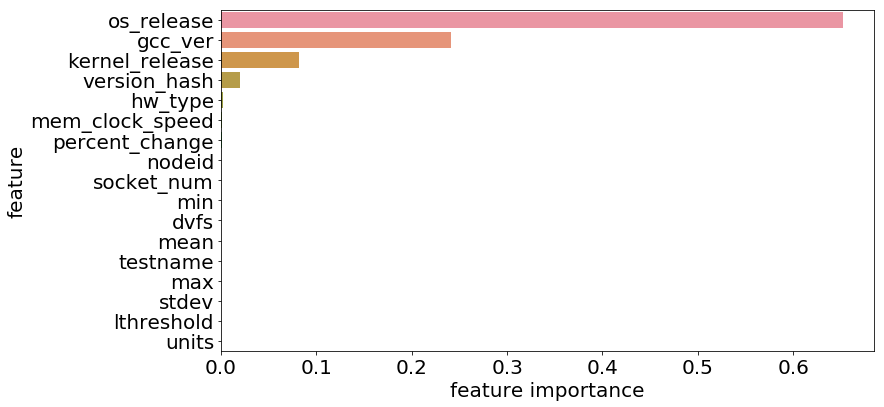

RMSE(XgBoost): 5.202039 days
RMSE(LightGBM): 5.790969 days
RMSE(CatBoost): 6.748461 days


In [41]:
X = memory_result[['hw_type', 'lthreshold', 'testname', 'dvfs', 'socket_num',
       'percent_change', 'nodeid', 'kernel_release', 'os_release', 'gcc_ver',
       'version_hash', 'mem_clock_speed', 'units', 'mean', 'min', 'max',
       'stdev']]
y = memory_result[['timestamp']]
categorical_cols = X.columns[X.dtypes==object].tolist()
le = LabelEncoder()
X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))

Memory = Data(X,y)
Memory.xgb()
Memory.lgb()
Memory.cb()

### CPU###

/Users/zhaoyuxuan/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


gcc_ver           0.377703
kernel_release    0.326896
version_hash      0.271891
hw_type           0.009024
os_release        0.004443
class             0.002075
dvfs              0.001742
nodeid            0.001374
total_threads     0.001330
exec_time         0.001257
percent_change    0.001158
testname          0.000687
socket_num        0.000287
lthreshold        0.000136
version           0.000000
dtype: float32


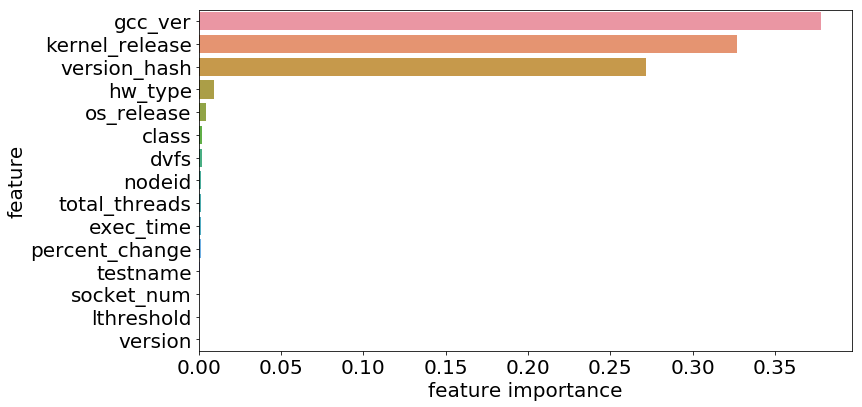

RMSE(XgBoost): 5.519595 days
RMSE(LightGBM): 5.880389 days
RMSE(CatBoost): 6.034927 days


In [42]:
X = cpu_result[['hw_type', 'lthreshold', 'testname', 'total_threads', 'dvfs',
       'socket_num', 'percent_change', 'class', 'nodeid', 'kernel_release', 
       'os_release', 'gcc_ver', 'version', 'version_hash', 'exec_time']]
y = cpu_result[['timestamp']]
categorical_cols = X.columns[X.dtypes==object].tolist()
X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))

Cpu = Data(X,y)
Cpu.xgb()
Cpu.lgb()
Cpu.cb()

### Disk ###

/Users/zhaoyuxuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/zhaoyuxuan/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


disk_size         0.270014
iodepth           0.125047
disk_model        0.100030
hw_type           0.093148
disk_serial       0.073326
mean              0.060746
nodeid            0.052682
percent_change    0.046401
max               0.043754
stdev             0.040315
min               0.034603
testname          0.029102
device            0.028088
lthreshold        0.002743
units             0.000000
dtype: float32


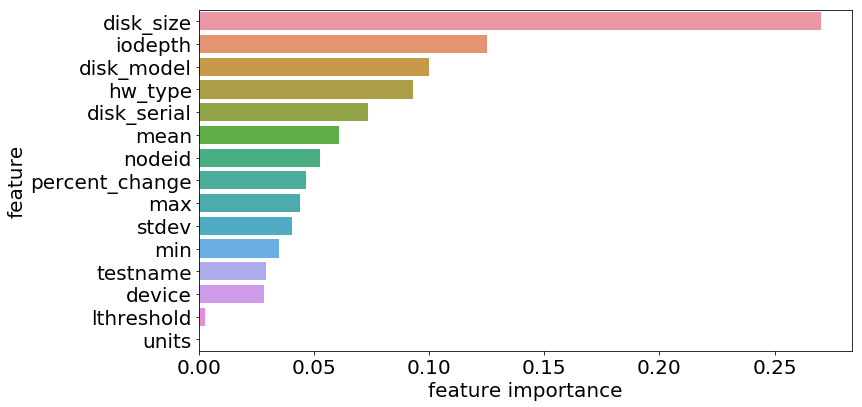

RMSE(XgBoost): 42.470911 days
RMSE(LightGBM): 47.653095 days
RMSE(CatBoost): 47.056258 days


In [43]:
X = disk_result[['hw_type', 'lthreshold', 'testname', 'device', 'iodepth',
          'percent_change', 'disk_model', 'disk_serial', 'disk_size', 
          'nodeid', 'units', 'mean', 'min', 'max', 'stdev']]
y = disk_result[['timestamp']]
categorical_cols = X.columns[X.dtypes==object].tolist()
X['disk_serial'] = le.fit_transform(X['disk_serial'].astype(str))
X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))

Disk = Data(X,y)
Disk.xgb()
Disk.lgb()
Disk.cb()